# Compare between

* Baseline = tp0
* 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import jax
from tqdm.notebook import tqdm

from graphufs.datasets import Dataset
from graphufs.batchloader import BatchLoader

from graphufs.utils import get_last_input_mapping, swap_dims

from channelconfig import TP0LightTester, TP0Light2Tester, TP0Light2NCTester, TP0Light2WSTester, TP02DayTester as TP0Tester

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [2]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
from functools import partial
import haiku as hk

from graphcast import rollout

from graphufs import construct_wrapped_graphcast
from graphufs.inference import swap_batch_time_dims

In [5]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=None,
) -> xr.Dataset:

    ckpt_id = emulator.num_epochs if ckpt_id is None else ckpt_id
    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    all_predictions = []
    all_targets = []
    for idx in tqdm(range(10)):
        inputs, targets, forcings = dataset.get_xarrays(idx)
        inputs.load()
        targets.load()
        forcings.load()
    
        # retrieve and drop t0
        inittimes = inputs.datetime.isel(time=-1).values
        inputs = inputs.drop_vars("datetime")
        targets = targets.drop_vars("datetime")
        forcings = forcings.drop_vars("datetime")
    
        predictions = rollout.chunked_prediction(
            gc,
            rng=jax.random.PRNGKey(0),
            inputs=inputs,
            targets_template=np.nan * targets,
            forcings=forcings,
        )
    
        # Add t0 as new variable, and swap out for logical sample/batch index
        predictions = swap_batch_time_dims(predictions, inittimes)
        targets = swap_batch_time_dims(targets, inittimes)
        all_predictions.append(predictions)
        all_targets.append(targets)

    all_predictions = xr.concat(all_predictions, dim="time")
    all_targets = xr.concat(all_targets, dim="time")

    return all_predictions, all_targets

In [57]:
experiments = {}
for Emulator, label in zip(
    [TP0Tester, TP0Light2WSTester, TP0Light2NCTester, TP0Light2Tester, TP0LightTester],
    ["Baseline", "Channel", "Channel NC", "Channel NCS", "Channel NCS 1IC"],
):
    stuff = dict()
    stuff["emulator"] = Emulator()
    stuff["dataset"] = Dataset(stuff["emulator"], mode="validation")
    stuff["predictions"], stuff["targets"] = predict(
        emulator=stuff["emulator"],
        dataset=stuff["dataset"],
    )
    experiments[label] = stuff

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Snapshots

In [58]:
tkw = lambda ax: dict(ha="left", va="center", backgroundcolor="white", transform=ax.transAxes)

In [61]:
def make_plot(vlist):
    nrows = 4
    ncols = len(vlist)
    fig, axs = plt.subplots(nrows, len(vlist), figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True, sharey=True)
    
    ilevel = 0
    itime = 1
    ilead = -1

    output_transforms = experiments["Baseline"]["emulator"].output_transforms
    
    for v, ax in zip(vlist, axs[1]):
        plotme = experiments["Baseline"]["targets"][v].isel(lead_time=ilead, time=itime).squeeze()
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)
        if v in output_transforms:
            plotme = output_transforms[v](plotme)
        plotme.plot(ax=ax, cbar_kwargs={"label": ""})
        ax.set(
            xlabel="",
            ylabel="Target" if ax.get_subplotspec().is_first_col() else "",
            title=v if ax.get_subplotspec().is_first_row() else "",
        )
    
    plotlist = {k : list() for k in vlist}

    for key, axr in zip(["Baseline", "Channel NC"], [axs[0], axs[2]]):

        for v, ax in zip(vlist, axr):
            plotme = experiments[key]["predictions"][v].isel(lead_time=ilead, time=itime).squeeze()
            target = experiments[key]["targets"][v].isel(lead_time=ilead, time=itime).squeeze()
            if "level" in plotme.dims:
                plotme = plotme.isel(level=ilevel, drop=True)
                target = target.isel(level=ilevel, drop=True)
                
            if v in output_transforms:
                plotme = output_transforms[v](plotme)
                target = output_transforms[v](target)
    
            plotlist[v].append(plotme)
            mae = np.abs(plotme - target).mean().values
            plotme.plot(ax=ax, cbar_kwargs={"label": ""})
            ax.set(
                xlabel="",
                ylabel=key if ax.get_subplotspec().is_first_col() else "",
                title=v if ax.get_subplotspec().is_first_row() else "",
            )
            ax.text(.15, .1, f"MAE = {mae:1.1e}", **tkw(ax))
            if "spfh" in v:
                ngz = (plotme<0).sum().values
                tot = int(len(plotme.lat) * len(plotme.lon))
                ax.text(.15, .9, f"{ngz} / {tot} < 0", **tkw(ax))
    for v, ax in zip(vlist, axs[-1]):
        diff = plotlist[v][1] - plotlist[v][0]
        diff.plot(ax=ax)
        ax.set(
            xlabel="",
            ylabel="row3 - row1" if ax.get_subplotspec().is_first_col() else "",
            title="",
        )
    return fig, axs 

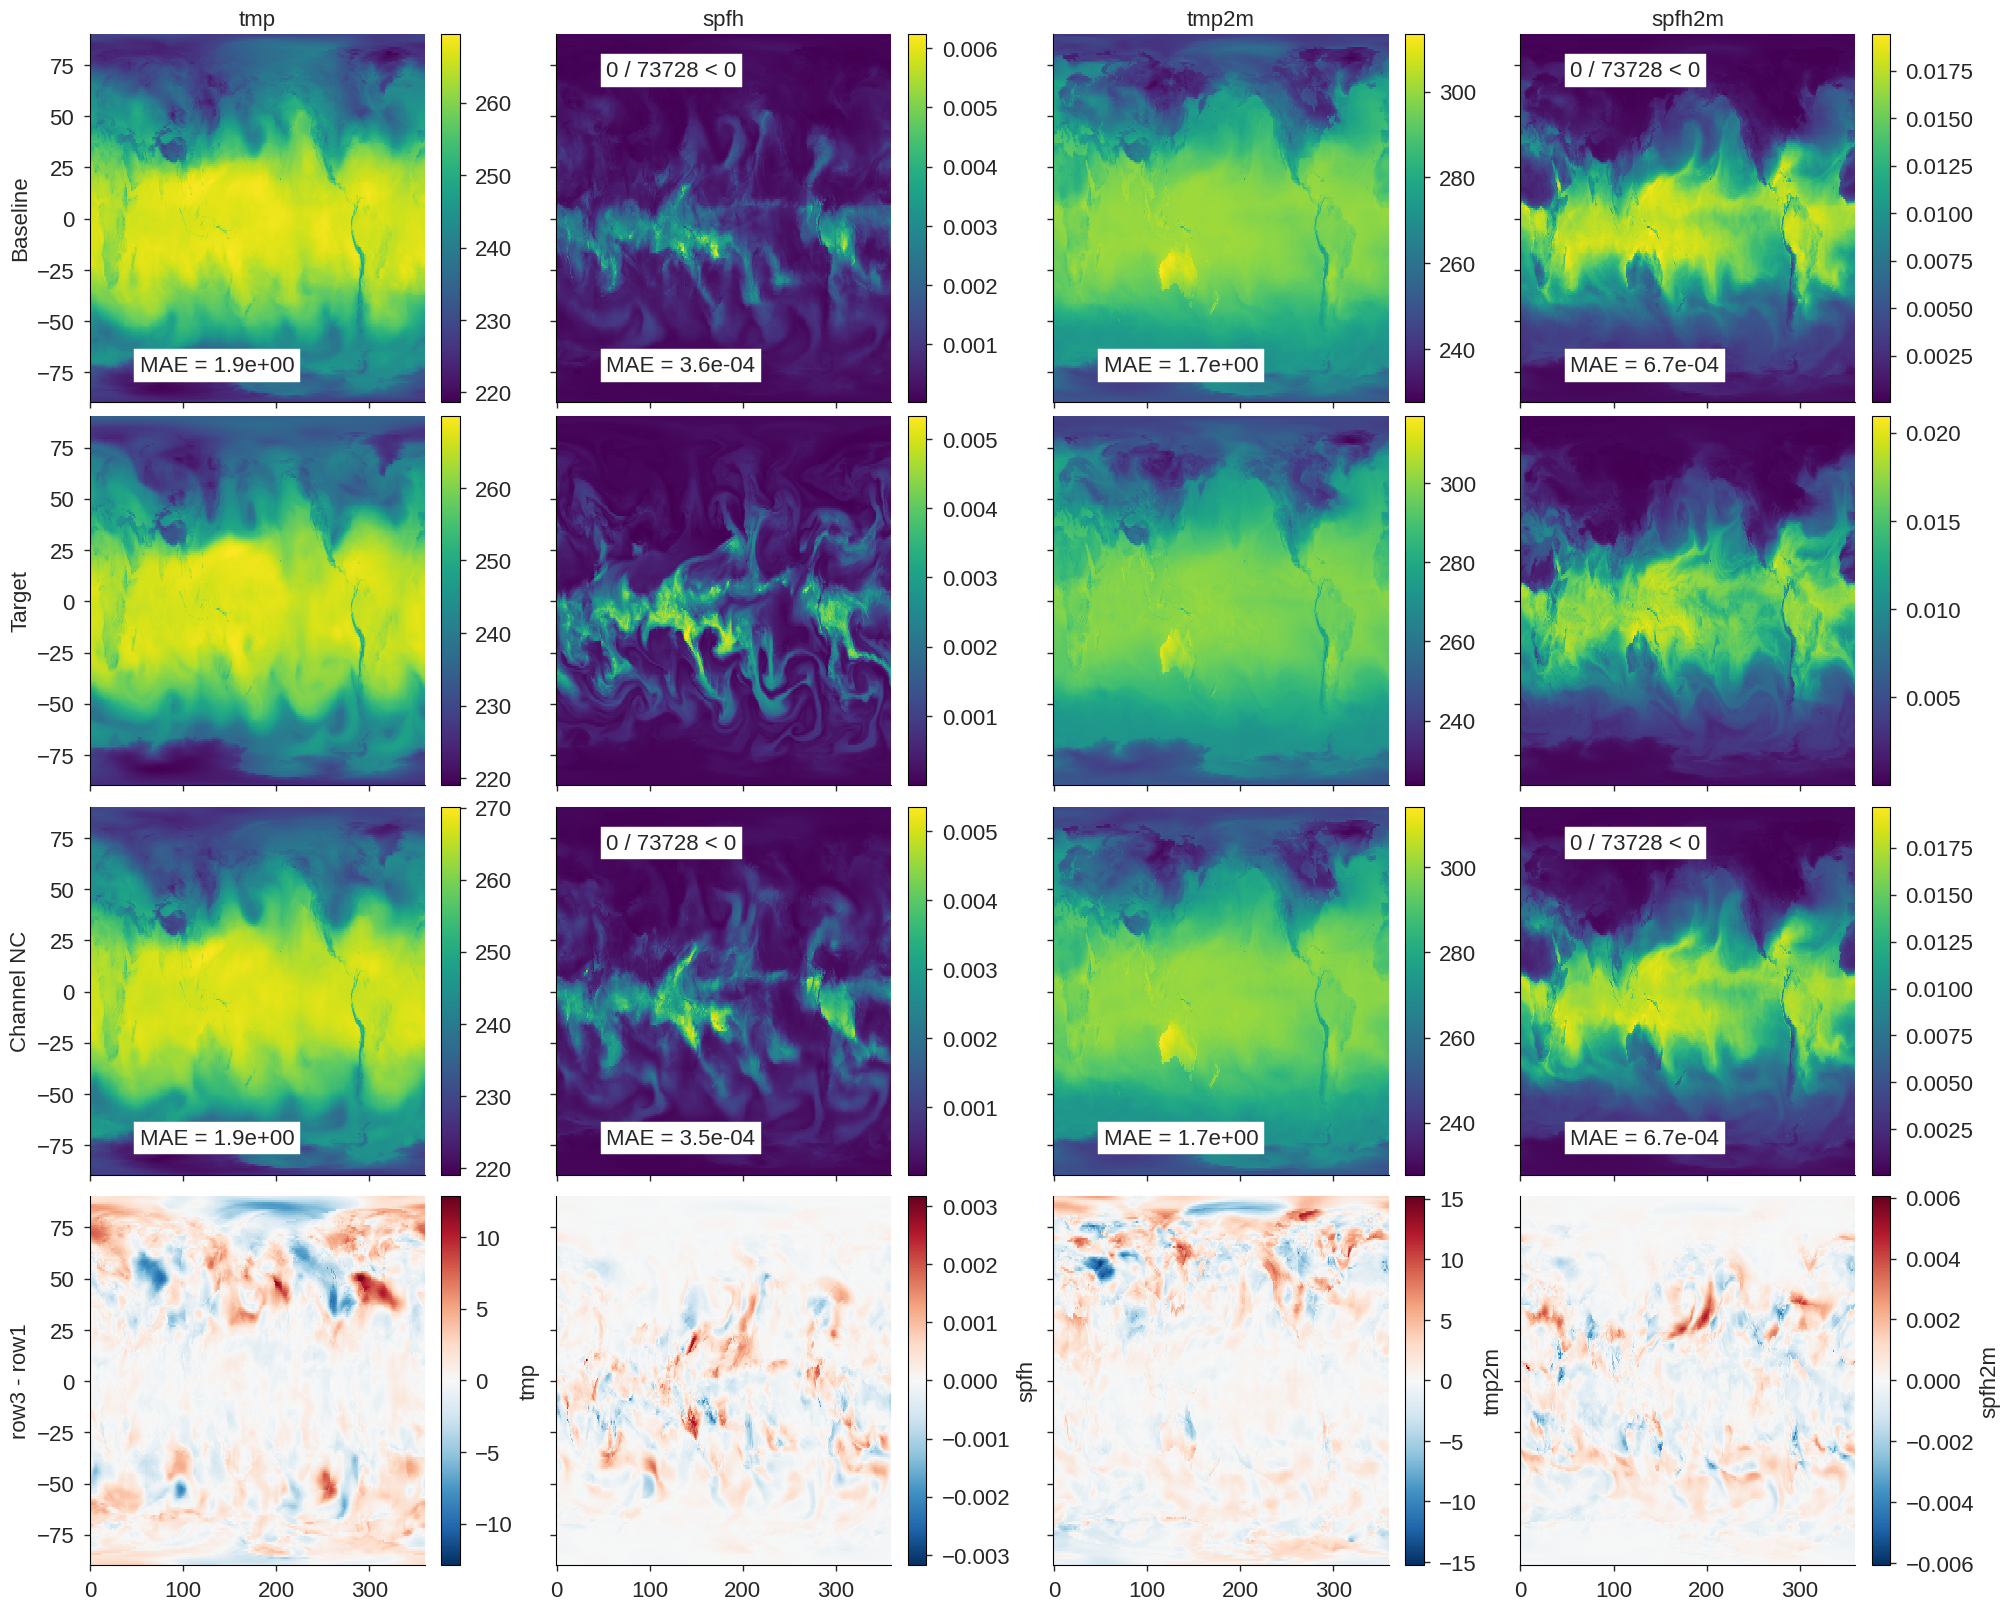

In [62]:
make_plot(["tmp", "spfh", "tmp2m", "spfh2m"]);

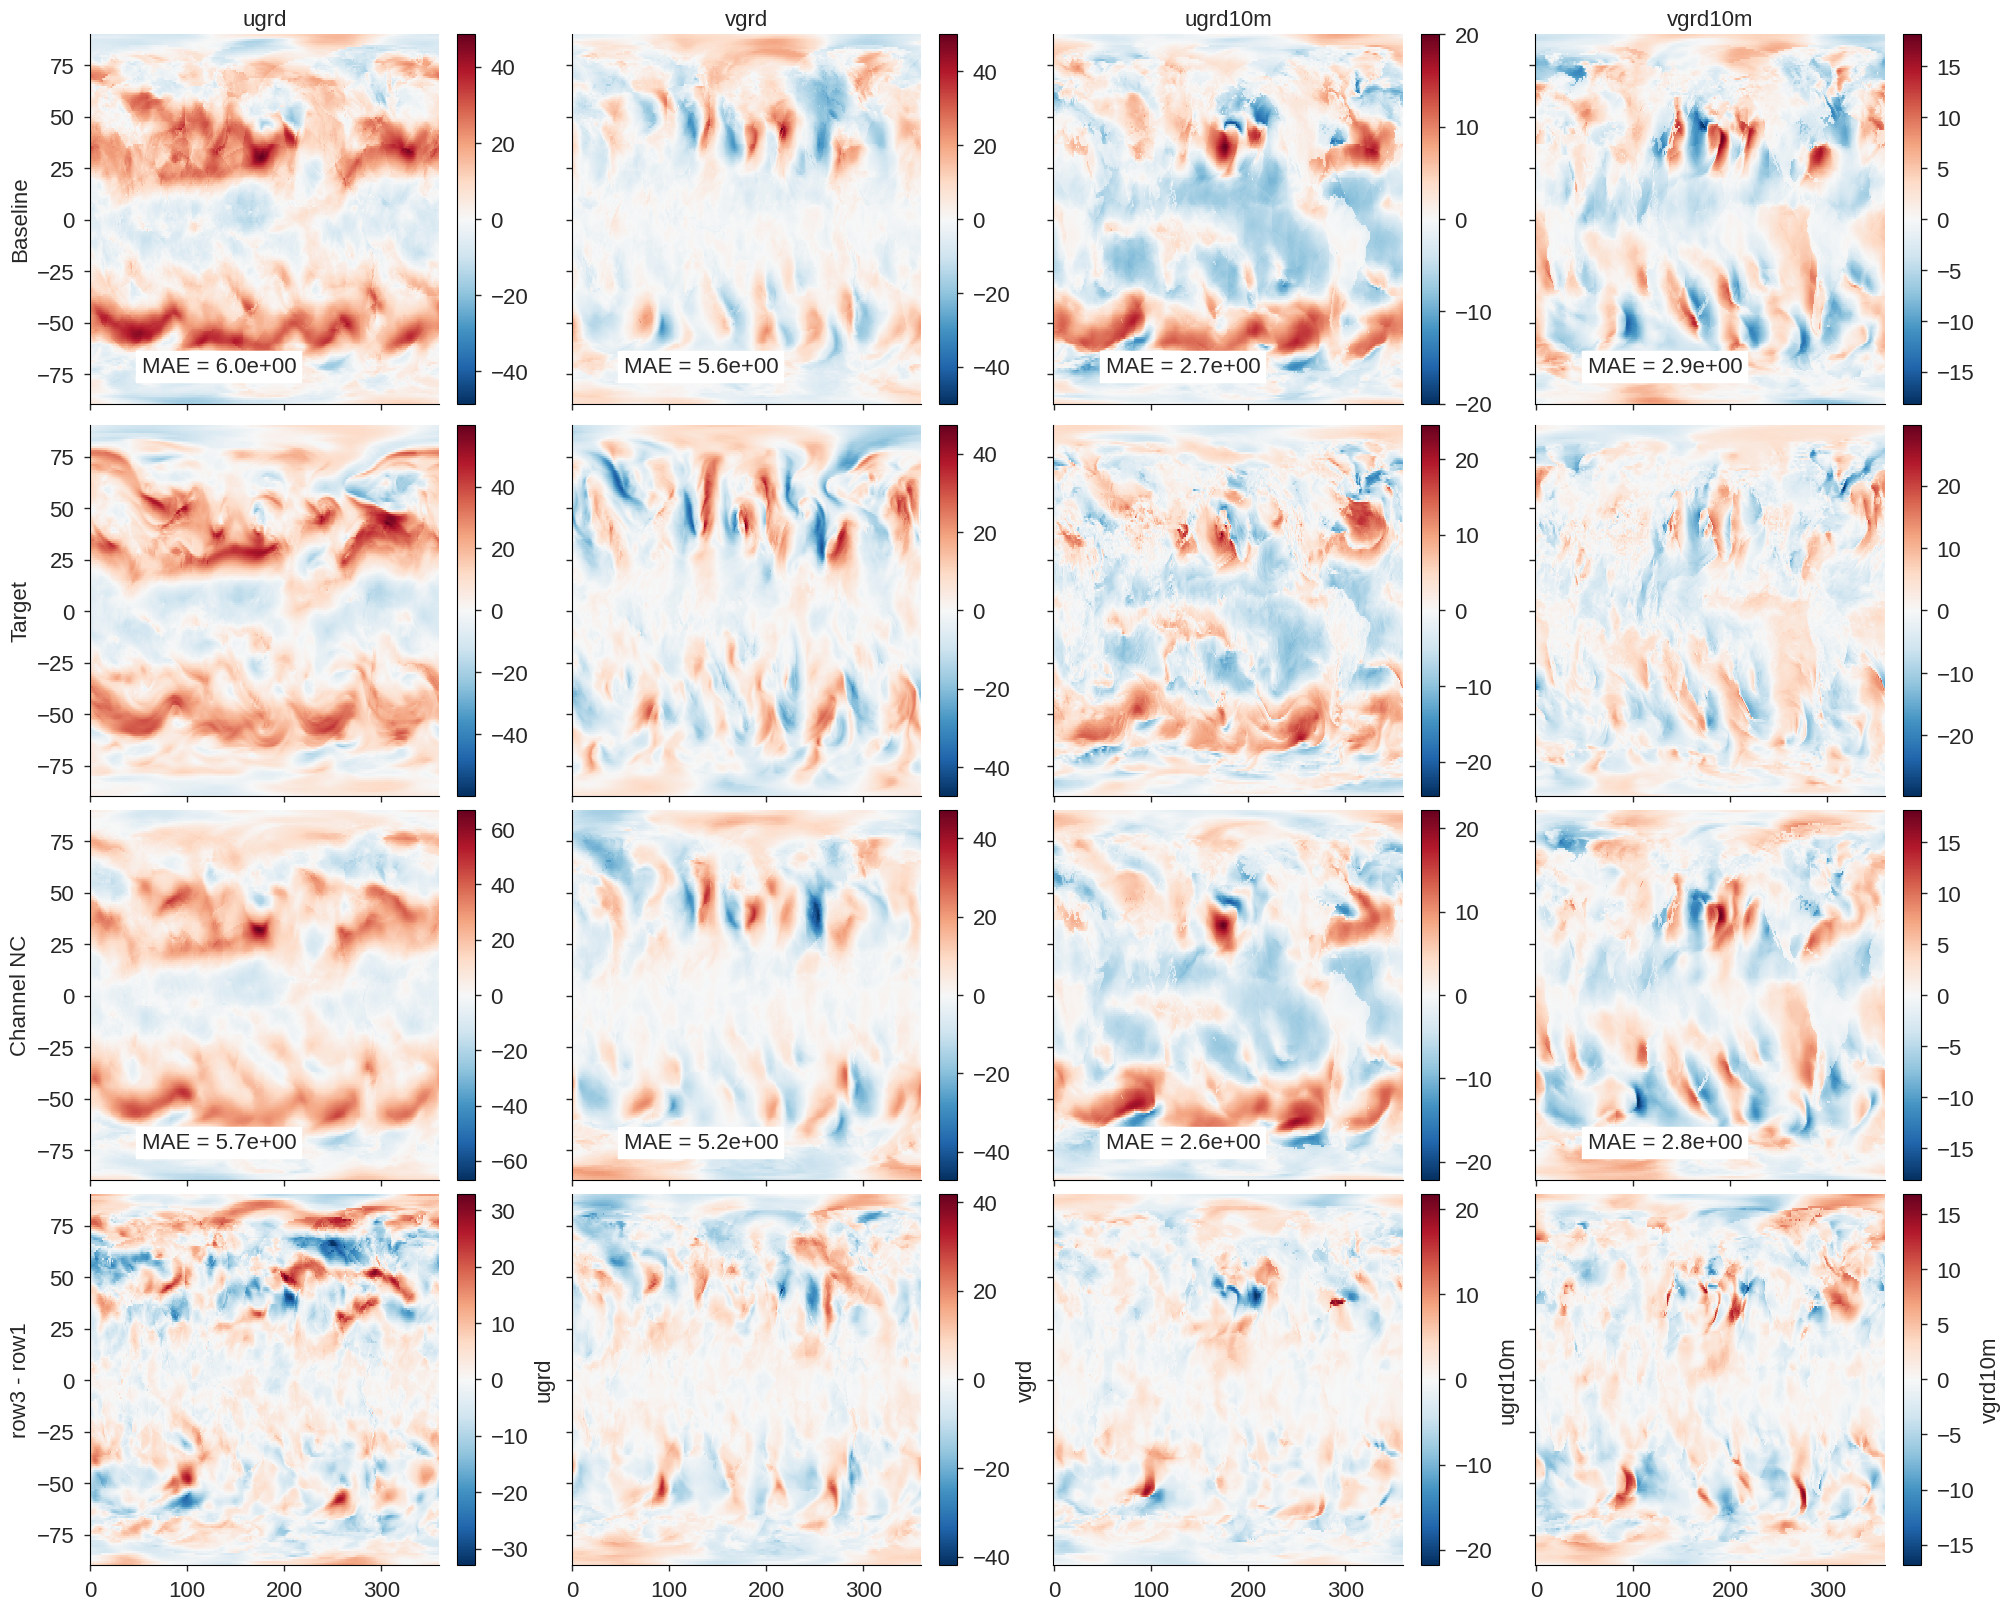

In [63]:
make_plot(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

## Plot Error

In [64]:
import seaborn as sns

In [65]:
def plot_error(varlist):
    nrows=1
    ncols = len(varlist)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True)

    ilevel = 1 

    output_transforms = experiments["Baseline"]["emulator"].output_transforms

    for v, ax in zip(varlist, axs):
        for ii, key in enumerate(experiments.keys()):
            p = swap_dims(experiments[key]["predictions"][v])
            t = swap_dims(experiments[key]["targets"][v])
            
            if "level" in p.dims:
                p = p.isel(level=ilevel)
                t = t.isel(level=ilevel)

            if v in output_transforms:
                p = output_transforms[v](p)
                t = output_transforms[v](t)

            plotme = np.abs(p-t).mean(["lat", "lon"]).squeeze()

            sns.lineplot(
                plotme.to_dataframe().reset_index(),
                x="fhr",
                y=v,
                ax=ax,
                color=f"C{ii}",
                errorbar="sd",
                label=key,
                legend=False,
            )
        ax.set(title=v, xticks=list(x for x in range(0, p.fhr.max().values+1, 6)))

    axs[-1].legend(loc="center left", bbox_to_anchor=(1, .5))
    return fig, axs

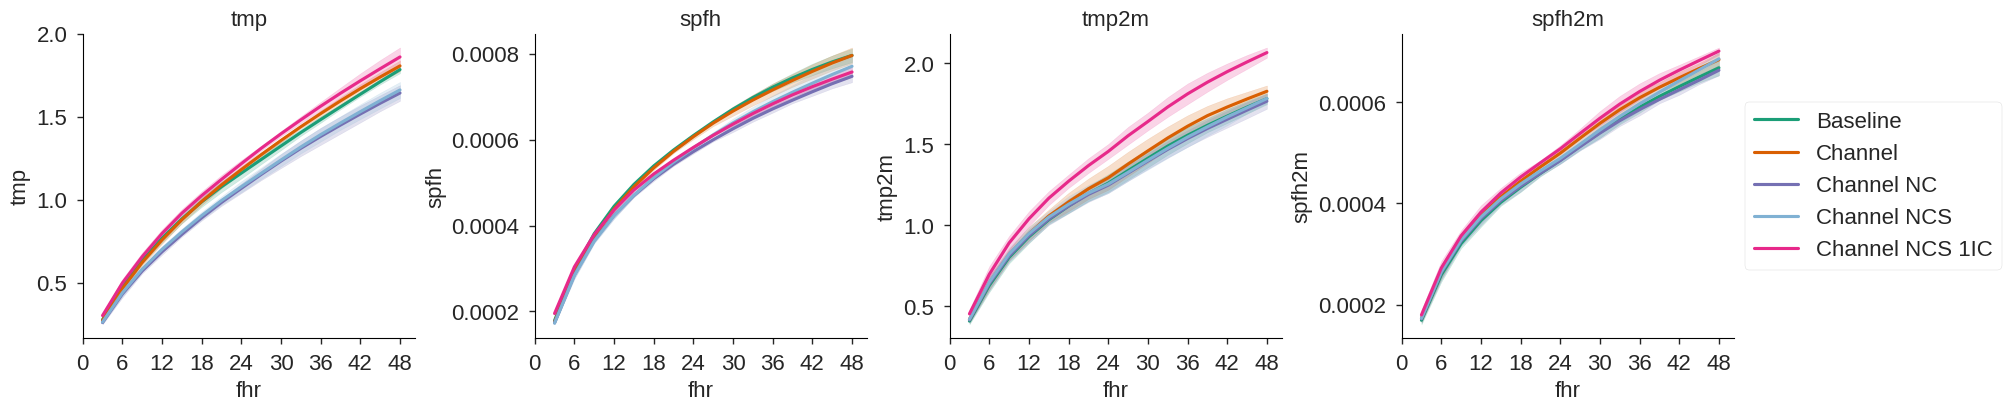

In [66]:
plot_error(["tmp", "spfh", "tmp2m", "spfh2m"]);

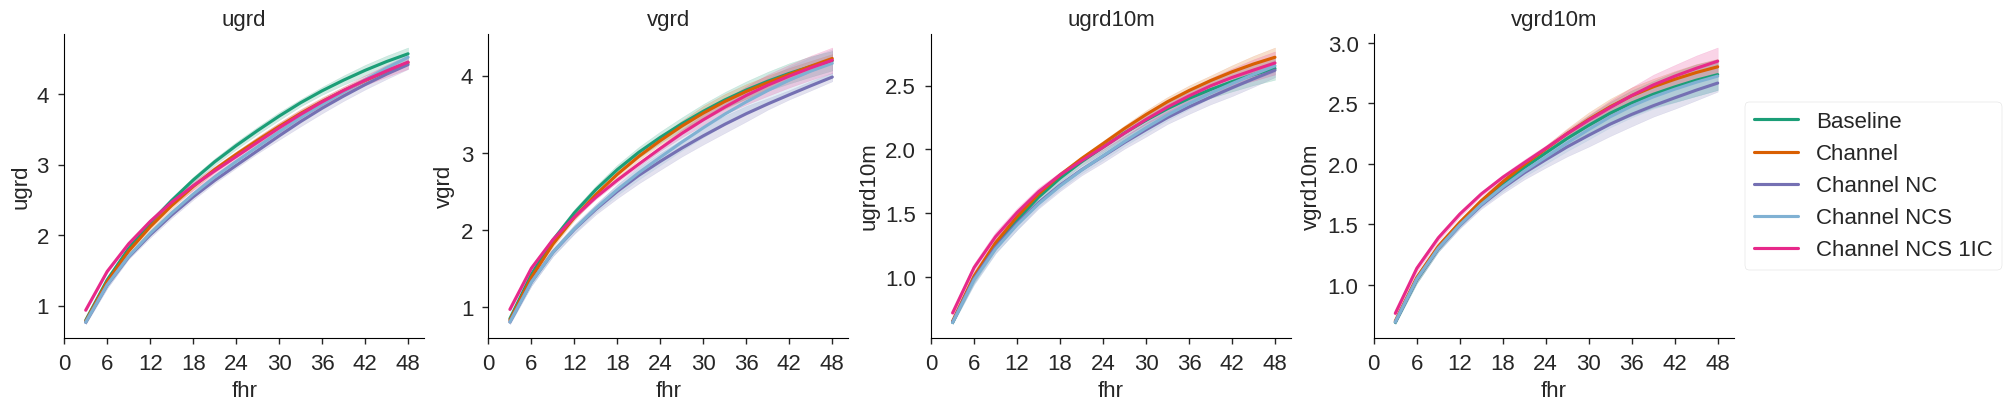

In [67]:
plot_error(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

### Spectra

In [49]:
def plot_spectra(vlist):
    ncols = len(vlist)
    fig, axs = plt.subplots(1, len(vlist), figsize=(ncols*5, 4), constrained_layout=True, sharex=True)
    
    ilevel = 1 
    itime = 0
    ilead = -1 
    
    output_transforms = experiments["Baseline"]["emulator"].output_transforms
    
    plotlist = {k : list() for k in vlist}
    for cid, key in enumerate(experiments.keys()):
        
        for v, ax in zip(vlist, axs):
            for xds, ls in zip(
                [experiments[key]["predictions"],
                 experiments[key]["targets"].copy(),
                ],
                ["-", ":"],
            ):
                computer = ZonalEnergySpectrum(v)
                plotme = xds[[v]].isel(time=itime).squeeze()
                plotme = plotme.rename({"lat": "latitude", "lon": "longitude"})
                if "level" in plotme.dims:
                    plotme = plotme.isel(level=ilevel, drop=True)
                plotme = plotme.isel(lead_time=ilead)
                if v in output_transforms:
                    plotme = output_transforms[v](plotme)
    
                plotme = plotme.compute()
                plotme = computer.compute(plotme)
                plotme = plotme.mean("latitude")
                plotme.plot(ax=ax, xscale="log", yscale="log", x="zonal_wavenumber", linestyle=ls, color=f"C{cid}", label=key)
            ax.set(title=v)
    axs[-1].legend(bbox_to_anchor=(1.1, .5), loc="center left")
    return fig, axs


[(0.0037583250125437927, 100.0)]

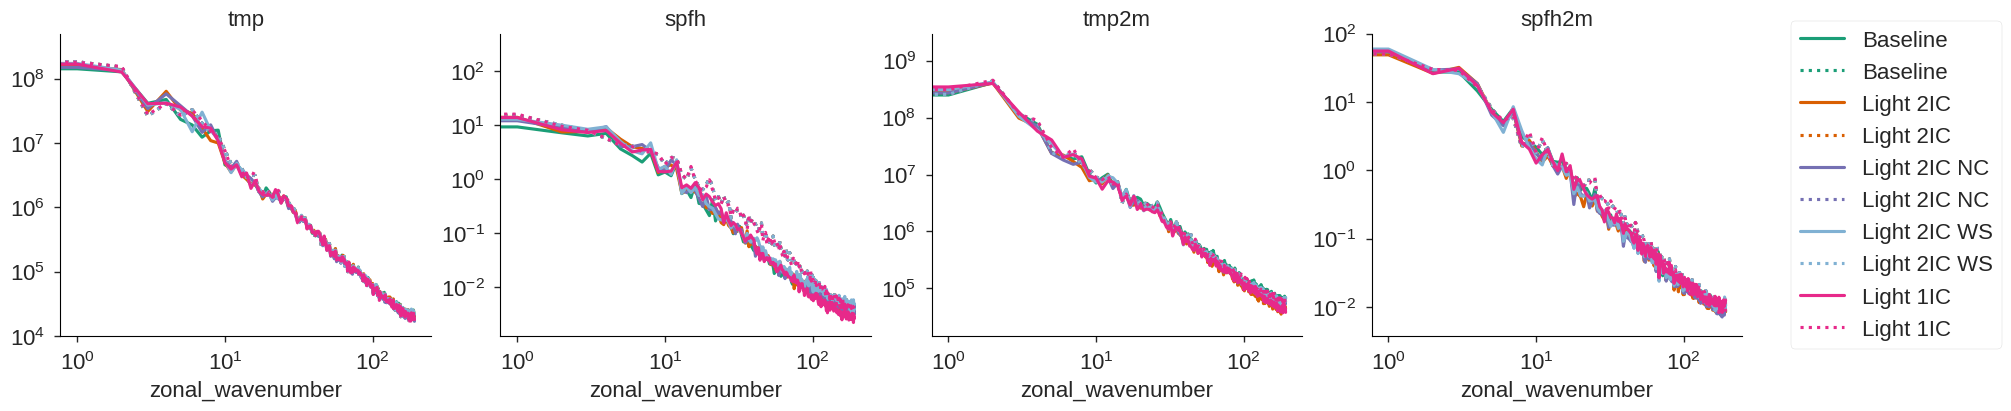

In [50]:
fig, axs = plot_spectra(["tmp", "spfh", "tmp2m", "spfh2m"])
axs[0].set(ylim=(1e4, 5e8))
#axs[1].set(ylim=(None, 1e1))
axs[2].set(ylim=(None, 3e9))
axs[3].set(ylim=(None, 1e2))


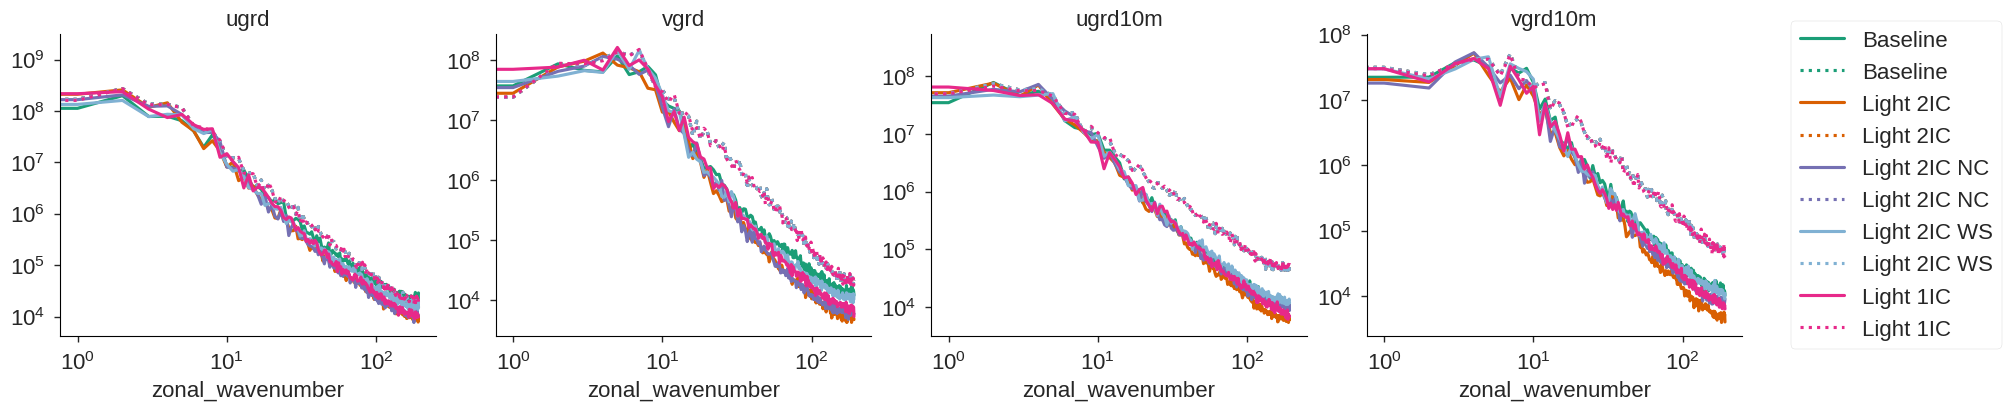

In [51]:
fig, axs = plot_spectra(["ugrd", "vgrd", "ugrd10m", "vgrd10m"])

## Loss


In [68]:
loss = {
    key: xr.open_dataset(f'{experiments[key]["emulator"].local_store_path}/loss.nc')
    for key in experiments.keys()
}

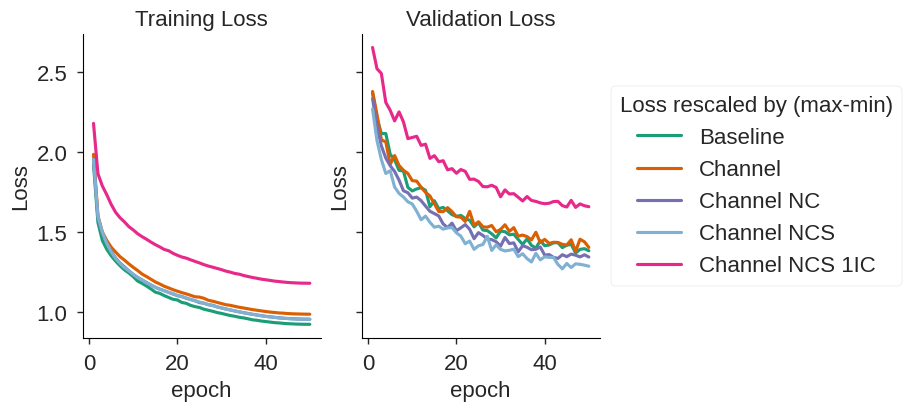

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharey=True)

for key, title, ax in zip(["loss_avg", "loss_valid"], ["Training Loss", "Validation Loss"], axs):
    for label, xds in loss.items():
        plotme = xds[key]
        plotme = plotme / (plotme.max() - plotme.min())
        plotme.plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
    ax.set(title=title, ylabel="Loss" if ax.get_subplotspec().is_first_row() else "")
    
axs[-1].legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))

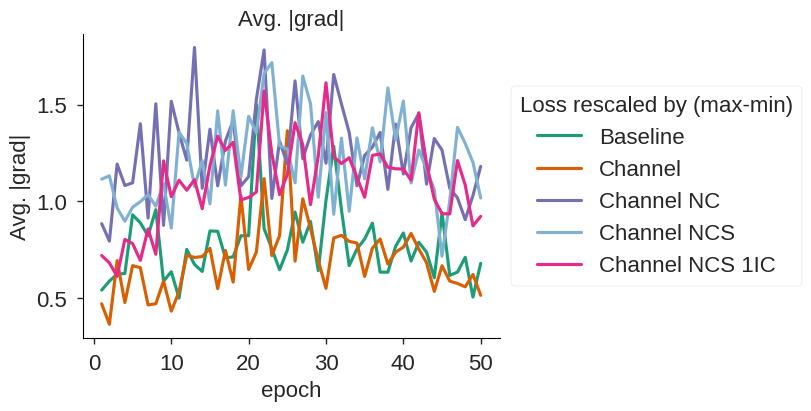

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)

key = "mgrad"
title = "Avg. |grad|"

for label, xds in loss.items():
    plotme = xds[key]
    plotme = plotme / (plotme.max() - plotme.min())
    plotme.plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
ax.set(title=title, ylabel="Avg. |grad|" if ax.get_subplotspec().is_first_row() else "")
    
ax.legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))

In [71]:
from prototypes.tp0.config import TP0Emulator
from channelconfig import TP0LightEmulator, TP0Light2Emulator, TP0Light2NCEmulator, TP0Light2WSEmulator

In [72]:
from graphufs.utils import get_channel_index

In [73]:
def convert_loss_channel2var(Emulator, loss2d):
    """

    Args:
        Emulator: note that it has to be the training emulator
        loss2d (xr.DataArray): second axis just has to be "channel"
    """
    em = Emulator()
    tds = Dataset(em, mode="training")

    _, xtargets, _ = tds.get_xarrays(0)
    tmeta = get_channel_index(xtargets)

    varloss = {}
    for cidx in loss2d.channel.values:
        mymeta = tmeta[cidx]
        varname = mymeta["varname"]
        this_loss = loss2d.sel(channel=cidx, drop=True)
        this_loss.name = varname
        if "level" in mymeta:
            levelval = xtargets.level.isel(level=mymeta["level"]).values
            this_loss = this_loss.expand_dims({"level": [levelval]})
            if varname not in varloss:
                varloss[varname] = [this_loss]
            else:
                varloss[varname].append(this_loss)
        else:
            varloss[varname] = this_loss

    for key in xtargets.data_vars:
        if "level" in xtargets[key].dims:
            varloss[key] = xr.concat(varloss[key], dim="level")
    return xr.Dataset(varloss)


In [74]:
vloss = {
    key: convert_loss_channel2var(Em, loss[key]["loss_by_channel_valid"])
    for Em, key in zip(
        [TP0Emulator, TP0Light2WSEmulator, TP0Light2NCEmulator, TP0Light2Emulator, TP0LightEmulator],
        ["Baseline", "Channel", "Channel NC", "Channel NCS", "Channel NCS 1IC"],
    )
}

In [75]:
vars3d = [v for v in vloss["Baseline"].data_vars if "level" in vloss["Baseline"][v].dims]
vars2d = [v for v in vloss["Baseline"].data_vars if "level" not in vloss["Baseline"][v].dims]
vars3d = ["tmp", "spfh", "ugrd", "vgrd"]
vars2d = ["tmp2m", "spfh2m", "ugrd10m", "vgrd10m", "pressfc"]

In [76]:
def plot_panel(xds, key, level=None, donorm=True, **kwargs):
    plotme = xds[key]
    if level is not None:
        plotme = plotme.sel(level=level)
    if donorm:
        rng = (plotme.max()-plotme.min()).values
        plotme = plotme / rng
        print(f"{label}, {key}: range = {rng:1.1e}")
    plotme.plot.line(**kwargs)
    

Baseline, tmp2m: range = 1.6e-01
Baseline, spfh2m: range = 2.6e-01
Baseline, ugrd10m: range = 2.9e-01
Baseline, vgrd10m: range = 3.2e-01
Baseline, pressfc: range = 2.6e-01
Channel, tmp2m: range = 9.2e-03
Channel, spfh2m: range = 1.5e-02
Channel, ugrd10m: range = 1.7e-02
Channel, vgrd10m: range = 1.7e-02
Channel, pressfc: range = 1.4e-02
Channel NC, tmp2m: range = 8.6e-03
Channel NC, spfh2m: range = 1.3e-02
Channel NC, ugrd10m: range = 1.6e-02
Channel NC, vgrd10m: range = 1.7e-02
Channel NC, pressfc: range = 1.9e-02
Channel NCS, tmp2m: range = 1.1e-02
Channel NCS, spfh2m: range = 1.5e-02
Channel NCS, ugrd10m: range = 1.6e-02
Channel NCS, vgrd10m: range = 1.8e-02
Channel NCS, pressfc: range = 2.1e-02
Baseline, tmp: range = 9.5e-02
Baseline, spfh: range = 9.1e-02
Baseline, ugrd: range = 9.2e-02
Baseline, vgrd: range = 1.1e-01
Channel, tmp: range = 1.6e-02
Channel, spfh: range = 1.5e-02
Channel, ugrd: range = 1.5e-02
Channel, vgrd: range = 1.8e-02
Channel NC, tmp: range = 1.5e-02
Channel N

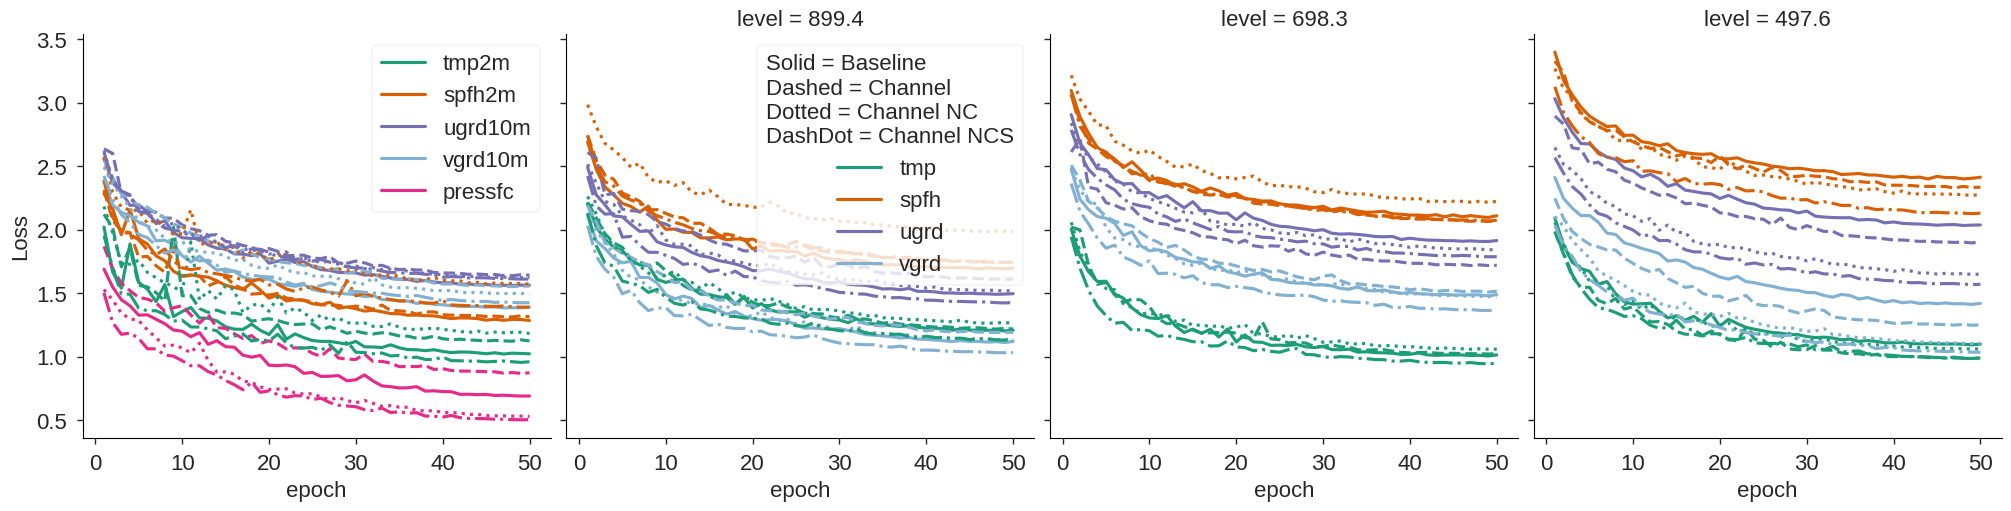

In [78]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True, sharey=True)

linestyles = ["-", "--", ":", "-."]

ax = axs[0]
for ls, (label, xds) in zip(linestyles, vloss.items()):
    for cid, key in enumerate(vars2d):
        plot_panel(
            xds=xds,
            key=key,
            x="epoch",
            ax=ax,
            ls=ls,
            label=key if ls=="-" else None,
            color=f"C{cid}",
        )
ax.set(ylabel="Loss")
ax.legend()
        
for level, ax in zip(xds.level.values[::-1], axs[1:]):
    for ls, (label, xds) in zip(linestyles, vloss.items()):
        for cid, key in enumerate(vars3d):
            plot_panel(
                xds=xds,
                key=key,
                level=level,
                x="epoch",
                ax=ax,
                ls=ls,
                label=key if ls=="-" else None,
                color=f"C{cid}",
            )
    ax.set(ylabel="")
    
   # kw = {}
   # if ax.get_subplotspec().is_last_col():
   #     kw["loc"] = "center left"
   #     kw["bbox_to_anchor"] = (1, .5)
axs[1].legend(title="Solid = Baseline\nDashed = Channel\nDotted = Channel NC\nDashDot = Channel NCS")

#axs[-1].legend(title="Loss rescaled by (max-min)", loc="center left", bbox_to_anchor=(1., .5))